# **Data Load**

In [18]:
import numpy as np
import pandas as pd

In [19]:
dna_forensics=pd.read_csv('/content/synthetic_dna_dataset.csv')
dna_forensics.head()

,Sample_ID,Sequence,GC_Content,AT_Content,Sequence_Length,Num_A,Num_T,Num_C,Num_G,kmer_3_freq,Mutation_Flag,Class_Label,Disease_Risk
0,SAMPLE_1,CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCG...,50.0,50.0,100,22,28,19,31,0.986,0,Bacteria,High
1,SAMPLE_2,TTGACCAAATTTGATTGGAAGTGGTAAGCGCGTATTCCTAGCATCA...,45.0,55.0,100,27,28,22,23,0.486,1,Virus,Medium
2,SAMPLE_3,GCGTGAGTTCTAATTTAAAAAGTCGTAACACGTACCCCGGCGTGTA...,51.0,49.0,100,26,23,30,21,0.367,1,Bacteria,Low
3,SAMPLE_4,ACTACGCGGACAAGAACCAACAGAACCTGGTTTTCGCAAGGGAGTG...,55.0,45.0,100,28,17,23,32,0.404,0,Human,Medium
4,SAMPLE_5,TTCAATGCAGATTGAAAGTTACTTTCATCTGCCCTATGGGTCCCTT...,46.0,54.0,100,24,30,25,21,0.818,0,Human,High


# **Problem Type:**

Multi-class classification. Predict the biological origin (source organism class) of a synthetic DNA sequence.

# **Data Preprocessing**

**Given Requirements:**
Objective: Clean and transform raw DNA into ML-ready data.

Tasks:

Convert sequences into k-mer embeddings (e.g., 3-mer “ATG,” “CCT”).

Use scikit-learn CountVectorizer or Keras Tokenizer to encode sequences.

Balance dataset (if skewed) using undersampling/oversampling.

Split into training, validation, and test sets.

In [20]:
print(f'Dataset shape: {dna_forensics.shape}')
print(f'Columns: {list(dna_forensics.columns)}')

Dataset shape: (3000, 13)
Columns: ['Sample_ID', 'Sequence', 'GC_Content', 'AT_Content', 'Sequence_Length', 'Num_A', 'Num_T', 'Num_C', 'Num_G', 'kmer_3_freq', 'Mutation_Flag', 'Class_Label', 'Disease_Risk']


In [21]:
dna_forensics.isnull().sum()

,0
Sample_ID,0
Sequence,0
GC_Content,0
AT_Content,0
Sequence_Length,0
Num_A,0
Num_T,0
Num_C,0
Num_G,0
kmer_3_freq,0


In [22]:
dna_forensics = dna_forensics.drop(columns=['Sample_ID'])
dna_forensics.head()

,Sequence,GC_Content,AT_Content,Sequence_Length,Num_A,Num_T,Num_C,Num_G,kmer_3_freq,Mutation_Flag,Class_Label,Disease_Risk
0,CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCG...,50.0,50.0,100,22,28,19,31,0.986,0,Bacteria,High
1,TTGACCAAATTTGATTGGAAGTGGTAAGCGCGTATTCCTAGCATCA...,45.0,55.0,100,27,28,22,23,0.486,1,Virus,Medium
2,GCGTGAGTTCTAATTTAAAAAGTCGTAACACGTACCCCGGCGTGTA...,51.0,49.0,100,26,23,30,21,0.367,1,Bacteria,Low
3,ACTACGCGGACAAGAACCAACAGAACCTGGTTTTCGCAAGGGAGTG...,55.0,45.0,100,28,17,23,32,0.404,0,Human,Medium
4,TTCAATGCAGATTGAAAGTTACTTTCATCTGCCCTATGGGTCCCTT...,46.0,54.0,100,24,30,25,21,0.818,0,Human,High


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Define target variable
y = dna_forensics['Class_Label']
X_seq = dna_forensics['Sequence']

print(y.value_counts())

Class_Label
Bacteria    761
Human       749
Plant       747
Virus       743
Name: count, dtype: int64


In [25]:
# create 3-mers from a sequence
k_mer_size = 3
def get_kmers(sequence, k=k_mer_size):
  return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

In [26]:
# apply 3-mer creation
k_mer_list = X_seq.apply(lambda x:' '.join(get_kmers(x, k=3)))

In [27]:
# using countvectorizer to get 3-mer counts
vectorizer = CountVectorizer(analyzer='word', ngram_range=(3,3), lowercase= False)
X_K_mer_matrix = vectorizer.fit_transform(k_mer_list)

print(f'3-mer feature matrix shape: {X_K_mer_matrix.shape}')
print(f'Number of unique 3 mers: {len(vectorizer.get_feature_names_out())}')

3-mer feature matrix shape: (3000, 1024)
Number of unique 3 mers: 1024


In [28]:
# slecting numerical features
numerical_features = ['GC_Content', 'AT_Content', 'Num_A', 'Num_T', 'Num_C', 'Num_G',
                      'kmer_3_freq', 'Mutation_Flag']
X_numerical = dna_forensics[numerical_features].reset_index(drop= True)

In [29]:
# k_mer counts + numerical features
from scipy.sparse import hstack, csr_matrix

X_numerical_sparse = csr_matrix(X_numerical.values)
X_combined = hstack([X_K_mer_matrix, X_numerical_sparse])
print(f'Final Feature matrix shape: {X_combined.shape}')

Final Feature matrix shape: (3000, 1032)


**Balancing the dataset using SMOTE**

In [30]:
#checking class
class_counts = y.value_counts()
print('Class Distribution: ', dict(class_counts))

# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

Class Distribution:  {'Bacteria': np.int64(761), 'Human': np.int64(749), 'Plant': np.int64(747), 'Virus': np.int64(743)}


In [31]:
# Apply SMOTE
X_combined_dense = X_combined.toarray()
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_combined_dense, y_encoded)

print(f'After SMOTE - Shape: {X_balanced.shape}')
print('New class distribution: ', dict(Counter(y_balanced)))

After SMOTE - Shape: (3044, 1032)
New class distribution:  {np.int64(0): 761, np.int64(3): 761, np.int64(1): 761, np.int64(2): 761}


In [32]:
# decode labels back
y_balanced_decoded = le.inverse_transform(y_balanced)

In [33]:
# train_test_split (1st split)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced_decoded, test_size=0.3, random_state= 42, stratify= y_balanced_decoded)

In [34]:
# 2nd split
X_val, X_temp, y_val, y_temp = train_test_split(X_test, y_test, test_size=0.5, random_state = 42, stratify = y_test)

In [35]:
print(f'Train: {X_train.shape},{len(y_train)}')
print(f'Validation: {X_val.shape}, {len(y_val)}')
print(f'test: {X_temp.shape}, {len(y_temp)}')

Train: (2130, 1032),2130
Validation: (457, 1032), 457
test: (457, 1032), 457


In [36]:
# saving preprocessed data
np.savez('preprocessed_dna.npz', X_train=X_train, X_val=X_val, X_test=X_test,
         y_train=y_train, y_val=y_val, y_test=y_test,
         feature_names=np.concatenate([vectorizer.get_feature_names_out(), numerical_features]),
         label_classes=le.classes_)

# **Apply Basic ML Models**

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
import joblib

In [38]:
data = np.load('preprocessed_dna.npz', allow_pickle=True)
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
label_classes = data['label_classes']

print(f'Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}')
print(f'Classes: {label_classes}')

Train: (2130, 1032), Val: (457, 1032), Test: (914, 1032)
Classes: ['Bacteria' 'Human' 'Plant' 'Virus']


In [39]:
# encode labels for ROC & AUC
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.fit_transform(y_val)
y_test_enc = le.fit_transform(y_test)

In [40]:
# define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class= 'ovr'),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs = -1),
    'SVM': SVC(probability=True, random_state=42)
}

In [41]:
# oneVSrest
ovr_models= {name: OneVsRestClassifier(model) for name, model in models.items()}

In [42]:
results = []

for name, model in ovr_models.items():
  print(f"\nTraining {name}...")

  model.fit(X_train,y_train_enc)

  y_val_pred = model.predict(X_val)
  y_val_prob = model.predict_proba(X_val)

  # metrics
  acc = accuracy_score(y_val_enc, y_val_pred)
  f1 = f1_score(y_val_enc, y_val_pred, average = 'macro')
  roc_auc = roc_auc_score(y_val_enc, y_val_prob, multi_class = 'ovr', average= 'macro')

  results.append({
      'Model':name,
      'Accuracy': round(acc,4),
      'F1 Score (macro)': round(f1,4),
      'ROC AUC (macro)': round(roc_auc,4)
  })
  print(f'Accuracy: {acc: .4f} | F1 Score: {f1: .4f} | ROC AUC: {roc_auc: .4f}')

  #saving
  joblib.dump(model, f'model_{name.lower().replace(' ','_')}.pkl')


Training Logistic Regression...
Accuracy:  0.2495 | F1 Score:  0.2498 | ROC AUC:  0.5009

Training Random Forest...
Accuracy:  0.2801 | F1 Score:  0.2798 | ROC AUC:  0.5463

Training SVM...
Accuracy:  0.2867 | F1 Score:  0.2870 | ROC AUC:  0.4806


**Final Test Set Evaluation**

In [43]:
# choosing best model by f1 score
best_model_info = max(results, key= lambda x: x['F1 Score (macro)'])
best_name = best_model_info['Model']
best_model = joblib.load(f'model_{best_name.lower().replace(' ','_')}.pkl')

In [44]:
# test prediction
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

# test matrics
test_acc = accuracy_score(y_test_enc, y_test_pred)
test_f1 = f1_score(y_test_enc, y_test_pred, average= 'macro')
test_auc = roc_auc_score(y_test_enc, y_test_proba, multi_class ='ovr', average= 'macro')

print(f"Best Model: {best_name}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-Score (macro): {test_f1:.4f}")
print(f"Test ROC-AUC (macro): {test_auc:.4f}")

Best Model: SVM
Test Accuracy: 0.2713
Test F1-Score (macro): 0.2716
Test ROC-AUC (macro): 0.4930


In [45]:
# full classification report
print(classification_report(y_test_enc, y_test_pred, target_names=label_classes))

              precision    recall  f1-score   support

    Bacteria       0.25      0.27      0.26       229
       Human       0.27      0.26      0.27       228
       Plant       0.29      0.28      0.28       229
       Virus       0.28      0.28      0.28       228

    accuracy                           0.27       914
   macro avg       0.27      0.27      0.27       914
weighted avg       0.27      0.27      0.27       914



# **Deep Learning Models**

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, LSTM, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib
import json
from tensorflow.keras import layers

In [64]:
# extract sequences and label values
sequences = dna_forensics['Sequence'].values
labels = dna_forensics['Class_Label'].values

# DNA alphabet(Adenine, Cytosine, Guanine, Thymine)
vocab = 'ACGT'
tokenizer = Tokenizer(char_level = True, filters = '', lower = False)
tokenizer.fit_on_texts(vocab)

#convert sequence
sequence_int = tokenizer.texts_to_sequences(sequences)
sequence_int = np.array(sequence_int)-1
max_len = 100
X = pad_sequences(sequence_int, maxlen= max_len, padding = 'post')

In [65]:
y = to_categorical(le.fit_transform(labels))
print(f'Classes: {list(le.classes_)}')

Classes: ['Bacteria', 'Human', 'Plant', 'Virus']


In [66]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42, stratify = labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val)
print(f'Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}')

Train: (2040, 100), Val: (510, 100), Test: (450, 100)


**Model Building**

In [71]:
def build_cnn():
  model = Sequential([
      Embedding(4,128, input_length = max_len),
      Conv1D(128,5, activation ='relu'),
      GlobalMaxPooling1D(),
      Dense(64,activation='relu'),
      Dropout(0.5),
      Dense(y.shape[1], activation='softmax')
  ])
  model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [72]:
def build_bilstm():
  model = Sequential([
      Embedding(4,128, input_length = max_len),
      Bidirectional(LSTM(164)),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(y.shape[1], activation='softmax')
  ])
  model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
  return model

**Train and Evaluate models**

In [75]:
models_dict = {'CNN': build_cnn(), 'BiLSTM': build_bilstm()}
results = []

for name, model in models_dict.items():
  print(f"\nTraining {name}...")
  model.fit(X_train, y_train, validation_data=(X_val, y_val),
            epochs=30, batch_size=32, callbacks=[EarlyStopping(patience=5)])

  # Explicitly save the model after training
  model.save(f'{name}_model.h5')

  # Load the saved model
  best = tf.keras.models.load_model(f'{name}_model.h5')
  preds = np.argmax(best.predict(X_test), axis=1)
  true = np.argmax(y_test, axis=1)
  acc = accuracy_score(true, preds)
  f1 = f1_score(true, preds, average='macro')
  results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1})
  print(f'{name} - Accuracy: {acc:.4f} | F1 Score: {f1:.4f}')


Training CNN...
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2525 - loss: 1.3910 - val_accuracy: 0.2490 - val_loss: 1.3881
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2420 - loss: 1.3877 - val_accuracy: 0.2510 - val_loss: 1.3863
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2338 - loss: 1.3868 - val_accuracy: 0.2529 - val_loss: 1.3865
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2416 - loss: 1.3872 - val_accuracy: 0.2451 - val_loss: 1.3861
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.2681 - loss: 1.3860 - val_accuracy: 0.2706 - val_loss: 1.3861
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2608 - loss: 1.3863 - val_accuracy: 0.2569 - val_loss: 1.3862
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2511 - loss: 1.3865 - val_accuracy: 0.2647 - val_loss: 1.3861
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2774 - loss: 1.3847 - val_acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
CNN - Accuracy: 0.2578 | F1 Score: 0.1638

Training BiLSTM...
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 442ms/step - accuracy: 0.2433 - loss: 1.3886 - val_accuracy: 0.2490 - val_loss: 1.3881
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 439ms/step - accuracy: 0.2677 - loss: 1.3865 - val_accuracy: 0.2431 - val_loss: 1.3921
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 435ms/step - accuracy: 0.2682 - loss: 1.3855 - val_accuracy: 0.2353 - val_loss: 1.3929
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.2918 - loss: 1.3848 - val_accuracy: 0.2216 - val_loss: 1.3964
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 442ms/step - accuracy: 0.2855 - loss: 1.3820 - val_accuracy: 0.2314 - val_loss: 1.3961
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 435ms/step - accuracy: 0.2897 - loss: 1.3810 - val_accuracy: 0.2235 - val_loss: 1.3993


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
BiLSTM - Accuracy: 0.2600 | F1 Score: 0.2609


In [79]:
# Compare and Save
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
best_model_name = results_df.iloc[0]["Model"]
print("\n Results:\n", results_df)
print(f"\n Best Model: {best_model_name}")

# Save artifacts
best_model = tf.keras.models.load_model(f"{best_model_name}_model.h5")
best_model.save("best_sequence_model.h5")
with open("dna_tokenizer.json", "w") as f:
    json.dump(tokenizer.to_json(), f)
joblib.dump(le, "label_encoder.pkl")
results_df.to_csv("model_results.csv", index=False)

print("\n Saved Files:")
print(" - best_sequence_model.h5")
print(" - dna_tokenizer.json")
print(" - label_encoder.pkl")
print(" - model_results.csv")


 Results:
     Model  Accuracy  F1 Score
1  BiLSTM  0.260000  0.260910
0     CNN  0.257778  0.163804

 Best Model: BiLSTM



 Saved Files:
 - best_sequence_model.h5
 - dna_tokenizer.json
 - label_encoder.pkl
 - model_results.csv


Loaded best_sequence_model.h5
Making predictions...
Plotting confusion matrices...


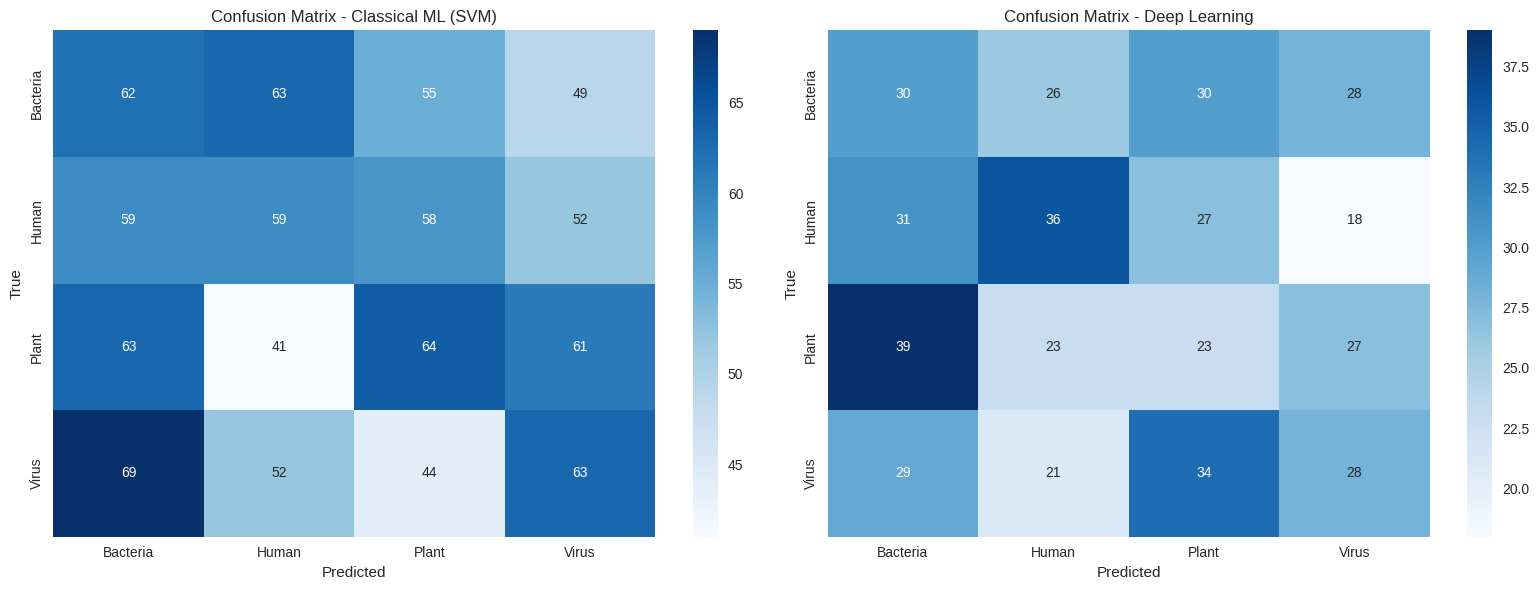

Plotting ROC curves...


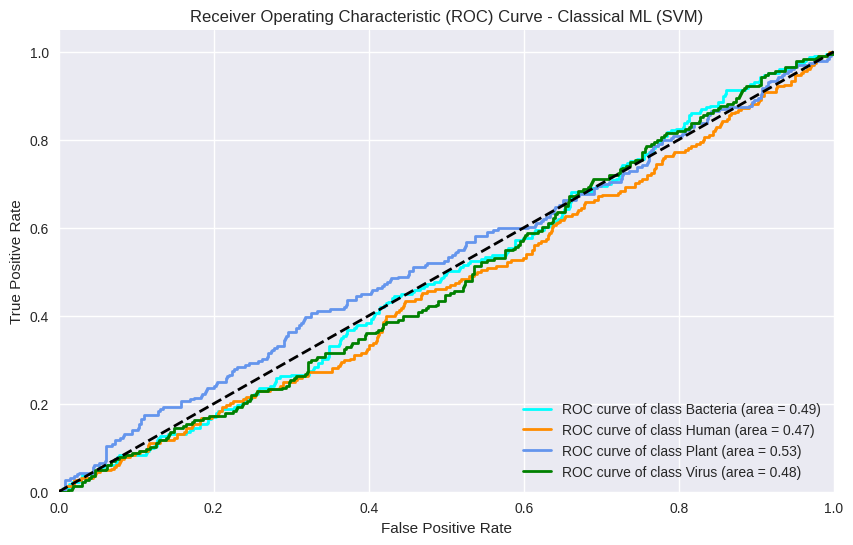

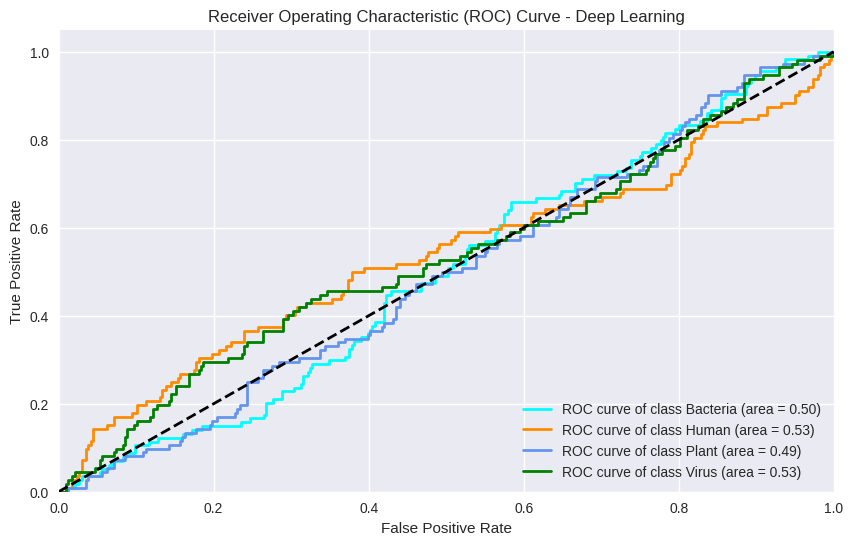

In [90]:
try:
    dl_model = load_model('best_sequence_model.h5')
    print("Loaded best_sequence_model.h5")
except:
    dl_model = load_model('best_CNN.h5')  # fallback
    print("Loaded best_CNN.h5")

with open('dna_tokenizer.json', 'r') as f:
    tokenizer_json = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)
le = joblib.load('label_encoder.pkl')

if 'X_test_seq_padded' not in locals() or 'y_test_seq' not in locals():
    print("Test sequence data (X_test_seq_padded, y_test_seq) not found. Please run cell b4141743 first.")
else:
    print("Making predictions...")
    X_seq_original = dna_forensics['Sequence'].values
    y_original = dna_forensics['Class_Label'].values


    X_seq_train_val, X_seq_test_consistent, y_train_val_seq, y_test_seq_consistent = train_test_split(
        X_seq_original, y_original, test_size=0.15, random_state=42, stratify=y_original
    )


    k_mer_list_test_consistent = pd.Series(X_seq_test_consistent).apply(lambda x:' '.join(get_kmers(x, k=3)))
    vectorizer_consistent = CountVectorizer(analyzer='word', ngram_range=(3,3), lowercase= False)

    k_mer_list_original = pd.Series(X_seq_original).apply(lambda x:' '.join(get_kmers(x, k=3)))
    vectorizer_consistent.fit(k_mer_list_original)
    X_K_mer_matrix_test_consistent = vectorizer_consistent.transform(k_mer_list_test_consistent)


    data = np.load('preprocessed_dna.npz', allow_pickle=True)
    X_test_ml = data['X_test']
    y_test_ml = data['y_test']
    label_classes_ml = data['label_classes']

    best_ml_model = joblib.load('model_svm.pkl')
    y_pred_ml = best_ml_model.predict(X_test_ml)
    y_pred_ml_proba = best_ml_model.predict_proba(X_test_ml)

    # Deep Learning: Use X_test_seq_padded from cell b4141743
    y_pred_dl_proba = dl_model.predict(X_test_seq_padded, verbose=0)
    y_pred_dl = np.argmax(y_pred_dl_proba, axis=1)


    y_pred_ml_labels = le.inverse_transform(y_pred_ml)
    y_pred_dl_labels = le.inverse_transform(y_pred_dl)


    print("Plotting confusion matrices...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    cm_ml = confusion_matrix(le.transform(y_test_ml), y_pred_ml, labels=le.transform(label_classes))
    sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_classes, yticklabels=label_classes, ax=axes[0])
    axes[0].set_title('Confusion Matrix - Classical ML (SVM)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    cm_dl = confusion_matrix(le.transform(y_test_seq), y_pred_dl, labels=le.transform(label_classes))
    sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_classes, yticklabels=label_classes, ax=axes[1])
    axes[1].set_title('Confusion Matrix - Deep Learning')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    # ==================== 4. ROC Curve ====================
    print("Plotting ROC curves...")


    y_test_ml_enc = le.transform(y_test_ml)
    y_test_ml_bin = label_binarize(y_test_ml_enc, classes=range(len(label_classes)))

    if hasattr(best_ml_model, 'predict_proba') and y_pred_ml_proba.shape == y_test_ml_bin.shape:
        plot_roc_curve(y_test_ml_bin, y_pred_ml_proba, label_classes, "Classical ML (SVM)")
    else:
        print("Skipping ROC curve for Classical ML: predict_proba not available or shape mismatch.")


    y_test_seq_enc = le.transform(y_test_seq)
    y_test_seq_bin = label_binarize(y_test_seq_enc, classes=range(len(label_classes)))

    if y_pred_dl_proba.shape == y_test_seq_bin.shape:
        plot_roc_curve(y_test_seq_bin, y_pred_dl_proba, label_classes, "Deep Learning")
    else:
        print("Skipping ROC curve for Deep Learning: predictions not available or shape mismatch.")